In [11]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
import matplotlib.pyplot as plt
import math
from inspect import isfunction
from functools import partial
from tqdm.auto import tqdm, trange
from einops import rearrange

import sys, os
sys.path.append("../") # important for relative imports to work

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from utils.datamodule import CIFAR10Datamodule
from models.unet import BaseUNet
train_dm = CIFAR10Datamodule("data",batch_size=32, train = True)
val_dm = CIFAR10Datamodule("data",batch_size=32, train = False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


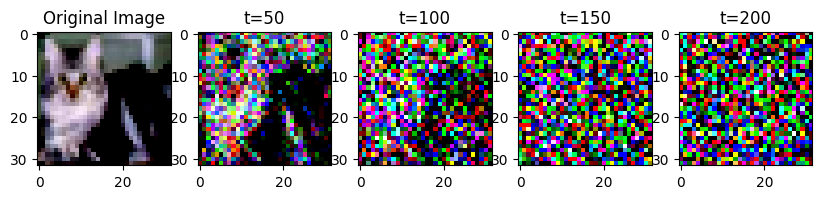

In [3]:
FORWARD_STEPS = 200
from train.beta_schedules import *
betas = cosine_beta_schedule(FORWARD_STEPS)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim = 0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

def forward_diffuse(x_0, t):
    """
    Perform the forward diffusion process, with:
    x0: input image of shape [B, C, H, W]
    t: input timesteps of shape [B]
    returns:
    x_t: noisy image at time step t of shape [B, C, H, W]
    noise: the generated gaussian noise
    """
    noise = torch.randn(x_0.shape, device = x_0.device) * sqrt_one_minus_alphas_cumprod[t]
    x_t = x_0 * sqrt_alphas_cumprod[t] + noise
    return x_t, noise

im = next(iter(train_dm.dataloader))[0][0]
im = im.unsqueeze(0)

ax, fig = plt.subplots(1, 5, figsize=(10, 5))
fig[0].imshow(im[0].permute(1, 2, 0))
fig[0].set_title("Original Image")
for i in range(1, 5):
    im, _ = forward_diffuse(im, i*50 - 1)
    fig[i].imshow(im[0].permute(1, 2, 0))
    fig[i].set_title(f"t={i*50}")

In [4]:
from models.unet import KarrasUNet
model = KarrasUNet(dim = 128)
epsilon_theta = model(im, torch.zeros(1))
assert epsilon_theta.shape == im.shape

In [5]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = model.to(device)
betas = betas.to(device); alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)

In [6]:
# Main Training Loop
NUM_EPOCHS = 5

from torch import optim
optimizer = optim.Adam(model.parameters(), lr=1e-5)

loss_ema = None
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dm.dataloader) as pbar:
        for x, class_label in pbar:
            x = x.to(device); class_label = class_label.to(device)
            # TODO: Condition on class label
            t = torch.randint(0, FORWARD_STEPS, (x.shape[0],), device = device)
            x_t, noise = forward_diffuse(x, t)
            epsilon_theta = model(x_t, torch.ones(1, device = device) * t)
            loss = F.mse_loss(epsilon_theta, x) # TODO: Experiment with l1 loss
            loss.backward()
            loss_ema = round(loss_ema * 0.95 + loss.item() * 0.05 if loss_ema else loss.item(), 3)
            optimizer.step()
            optimizer.zero_grad()
            pbar.set_postfix({"Training loss": loss_ema})

    validation_loss = []
    with torch.no_grad():
        with tqdm(val_dm.dataloader) as pbar:
            for x, class_label in pbar:
                x = x.to(device); class_label = class_label.to(device)
                t = torch.randint(0, FORWARD_STEPS, (x.shape[0],))
                x_t, noise = forward_diffuse(x, torch.ones(1, device = device) * t)
                epsilon_theta = model(x_t, t)
                loss = F.mse_loss(epsilon_theta, x)
                validation_loss.append(loss.item())
    mean_val_loss = sum(validation_loss) / len(validation_loss)
    print(f"Epoch {epoch}. Validation loss: {mean_val_loss:.3f}")

  0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/199 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Denoised Image')

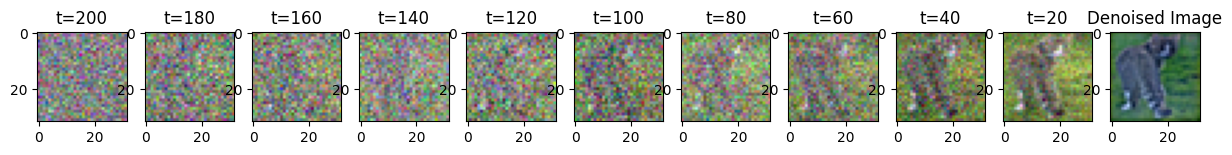

In [18]:
# Sampling process
def denoising_step(x_t, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    x: input image at timestamp t [B, C, H, W]
    t: the timestamp [B]
    """
    with torch.no_grad():
        epsilon_theta = model(x, torch.ones(1, device = device) * t)
        bar_alpha_t = alphas_cumprod[t]
        alpha_t = alphas[t]
        ratio = (1 - alpha_t) / torch.sqrt(1 - bar_alpha_t)

        var_t = 1 - bar_alpha_t
        z = torch.randn(x.shape, device = epsilon_theta.device)

        x_t_minus_1 = ((x - ratio * epsilon_theta) / torch.sqrt(alpha_t)) 
        if t != 0: x_t_minus_1 += torch.sqrt(var_t) * z
        return x_t_minus_1
    
# Visualize
fig, ax = plt.subplots(1, 11, figsize=(15, 5))
im = torch.randn(im.shape, device = device) * sqrt_one_minus_alphas_cumprod[0]
to_show = im[0].permute(1, 2, 0).cpu()
to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
ax[0].imshow(to_show)
ax[0].set_title("t=200")
for step in reversed(trange(1, FORWARD_STEPS)):
    im = denoising_step(im, step)
    if step % 20 == 0:
        to_show = im[0].permute(1, 2, 0).cpu()
        # Normalize between -1 and 1
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        ax[FORWARD_STEPS // 20 - step // 20].imshow(to_show)
        ax[FORWARD_STEPS // 20 - step // 20].set_title(f"t={step}")

to_show = im[0].permute(1, 2, 0).cpu()
to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
ax[-1].imshow(to_show)
plt.title("Denoised Image")